In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn as nn

from rlforge.agents.policy_gradient import PPOContinuous
from rlforge.experiments import ExperimentRunner
from rlforge.environments import PIDStatic

In [14]:
env = PIDStatic(w=0.2, dt=0.1, episode_len=1000)
n = 64

policy_net = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], n), nn.Tanh(),
    nn.Linear(n,n), nn.Tanh(),
    nn.Linear(n, env.action_space.shape[0])
)
value_net = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], n), nn.Tanh(),
    nn.Linear(n,n), nn.Tanh(),
    nn.Linear(n, 1)
)

agent = PPOContinuous(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    policy_net=policy_net,                # nn.Module: outputs mean (B, action_dim)
    value_net=value_net,                 # nn.Module: outputs value (B, 1)
    actor_lr=0.003,
    critic_lr=0.003,
    discount=0.99,            # γ
    gae_lambda=0.95,          # λ for GAE
    clip_epsilon=0.2,
    update_epochs=10,
    mini_batch_size=64,
    rollout_length=256,
    value_coef=0.5,
    entropy_coeff=0.001,
    max_grad_norm=1.0,
    tanh_squash=True,         # if True: tanh on actions; pass bounds
    action_low=env.action_space.low,           # tensor or float, used if tanh_squash=False
    action_high=env.action_space.high,          # tensor or float, used if tanh_squash=False
    device='cpu'
)

d:\Proyectos\rlforge\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
d:\Proyectos\rlforge\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [15]:
runner = ExperimentRunner(env, agent)

results = runner.run_episodic(
    num_runs=1,
    num_episodes=50,
    max_steps_per_episode=None
)

rewards = results["rewards"]
steps = results['steps']

runner.summary(last_n=20)

 Experiment Summary (Episodic)
Runs: 1
Average runtime per run: 67.989 seconds
Episodes per run: 50
First episode mean reward: 6.855
Last episode mean reward: -50.218
Overall mean reward: 1.921
Mean reward (last 20 episodes): -11.080
First episode mean steps: 1000.0
Last episode mean steps: 1000.0
Overall mean steps: 1000.0


In [19]:
print(env.current_pid)

[0.17847168 0.66064644 1.719678  ]


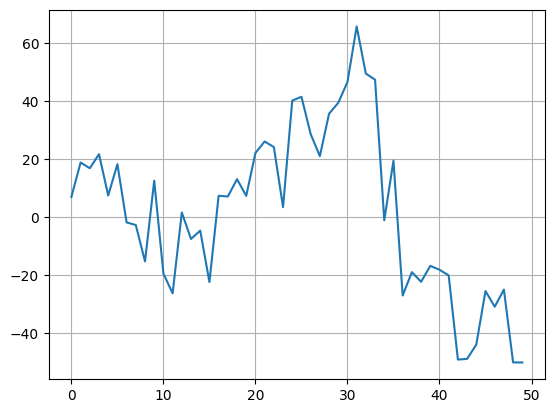

In [20]:
runs_std = np.std(rewards, axis=1)
runs_mean = np.mean(rewards, axis=1)
lower_bound = runs_mean - runs_std
upper_bound = runs_mean + runs_std
plt.plot(runs_mean)
plt.fill_between(np.arange(len(runs_mean)), lower_bound, upper_bound, alpha=0.3)
plt.grid()

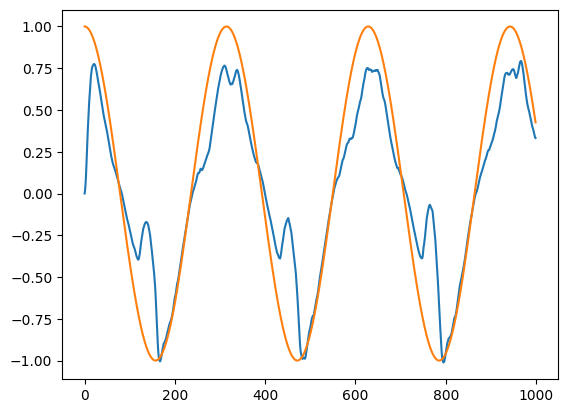

In [18]:
env.reset()
states = []
setpoint = []
truncated = False
action = [0.0, 0.0, 0.0]

while not truncated:

    new_state, reward, terminated, truncated, _ = env.step(action)
    action = agent.end(reward) if terminated else agent.step(reward, new_state)
    states.append(new_state[0])
    setpoint.append(env.setpoint)

plt.plot(states)
plt.plot(setpoint)